<a href="https://colab.research.google.com/github/Chinmay-1907/Alzheimer-s_Severity_Prediction_Model-/blob/main/IMG_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import kagglehub
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


from tensorflow import keras

from tensorflow.keras import layers, models
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:


# Download the dataset (ensure the dataset is downloaded correctly)
path = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset")

# Within this data set there are two seprate files one with
# Define the new path focusing only on the "OriginalDataset"
original_dataset_path = os.path.join(path, "OriginalDataset")

# Check the four classes within "OriginalDataset"
# Load the images from the directory
image_size = 200  # Standard size, can be adjusted
batch_size = 32

# Load only the "OriginalDataset"
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    original_dataset_path,
    batch_size=batch_size,
    image_size= (image_size,image_size),
    label_mode="categorical",  # Use "categorical" for one-hot encoded labels
    shuffle=True
)


100%|██████████| 380M/380M [00:04<00:00, 85.7MB/s]

Extracting files...


Found 6400 files belonging to 4 classes.


In [ ]:

# Check the new class names
channels = 3  # RGB channels

class_names = dataset.class_names
print("Class Names in OriginalDataset:", class_names)

Class Names in OriginalDataset: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [ ]:
len(dataset)

200

In [ ]:
for batch, labels in dataset.take(1):
    print("Batch Shape:", batch.shape)
    print("Labels Shape:", labels.shape)

Batch Shape: (32, 200, 200, 3)
Labels Shape: (32, 4)



 We are understanding our data set we have each batch as a batch of 32 images and every image is shaped 224 by 224 with 3 values for RGB

In [ ]:
print(batch[0].numpy)

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(200, 200, 3), dtype=float32, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=floa

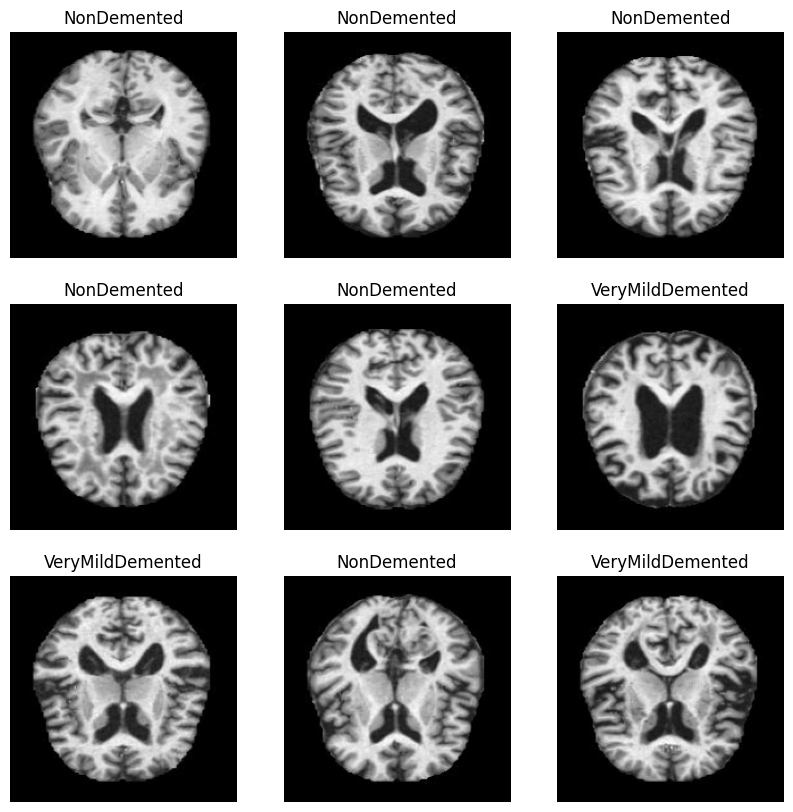

In [ ]:

plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

Now split our data into train test split

80% for training - The datset well use to train our model

10% for Validation - End of each epoch to use validation

10% Test data set - Use the test dataset at the end of all ephocs to check for our accuracy and test the perfomance

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

In [ ]:
dataset.shuffle(100000)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)


In [ ]:
 len(train_dataset)

160

In [ ]:
len(val_dataset)

20

In [ ]:
len(test_dataset)

20

In [ ]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


Data Augmentation: Use one image and create augmented images to make a more robust model

In [ ]:
resize_and_scale = Sequential([
    layers.Resizing(image_size, image_size),
    layers.Rescaling(1.0/255),
])

In [ ]:
Data_Augmentating  = Sequential([
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomContrast(0.2),
  layers.RandomFlip(mode='horizontal'),
  layers.RandomFlip(mode='vertical'),
  layers.RandomFlip(mode='horizontal_and_vertical'),
])

In [ ]:
input_shape=(batch_size, image_size, image_size, channels)

model = Sequential([
    resize_and_scale,
    Data_Augmentating,
    layers.Conv2D(32, (3,3), activation="relu", input_shape = (image_size,image_size,channels)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.5),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="softmax"),

])



In [ ]:
model.summary()

In [ ]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=85,
    validation_data=val_dataset,
)

Epoch 1/85
160/160 ━━━━━━━━━━━━━━━━━━━━ 29s 92ms/step - accuracy: 0.4889 - loss: 1.0804 - val_accuracy: 0.4938 - val_loss: 1.2020
Epoch 2/85
160/160 ━━━━━━━━━━━━━━━━━━━━ 27s 75ms/step - accuracy: 0.5015 - loss: 1.0419 - val_accuracy: 0.5000 - val_loss: 1.0795
Epoch 3/85
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.5182 - loss: 0.9983 - val_accuracy: 0.5188 - val_loss: 0.9789
Epoch 4/85
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.5286 - loss: 0.9600 - val_accuracy: 0.4094 - val_loss: 1.1201
Epoch 5/85
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.5104 - loss: 0.9745 - val_accuracy: 0.5047 - val_loss: 1.0219
Epoch 6/85
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.5478 - loss: 0.9431 - val_accuracy: 0.5328 - val_loss: 0.9676
Epoch 7/85
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.5416 - loss: 0.9409 - val_accuracy: 0.4953 - val_loss: 1.0230
Epoch 8/85
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.5458 - loss: 0.9332 - 

In [ ]:
score = model.evaluate(test_dataset)

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7743 - loss: 0.5909


In [ ]:
history.history["accuracy"]

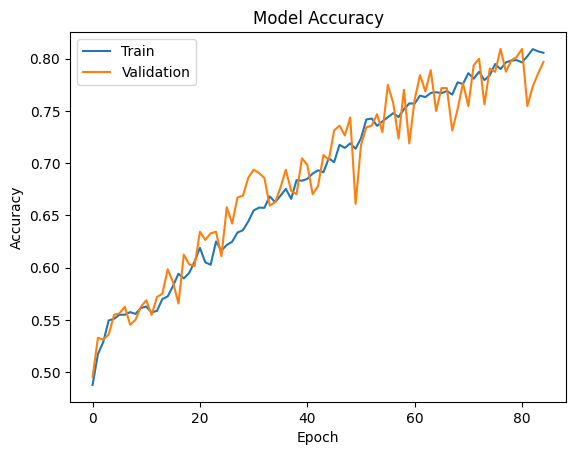

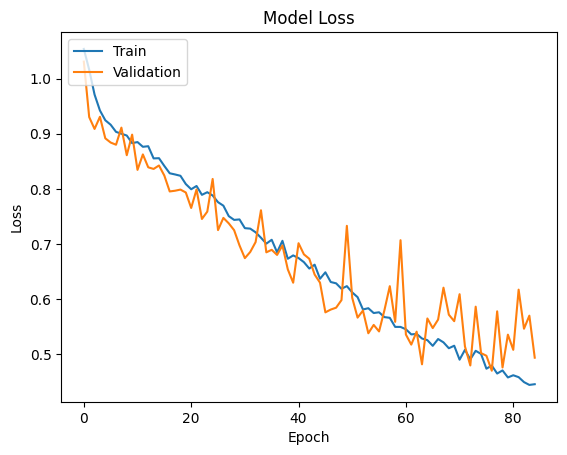

In [ ]:
# prompt: plot it

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Make predictions on the test dataset
predictions = model.predict(test_dataset)

# Get the true labels from the test dataset
true_labels = []
for images, labels in test_dataset:
  true_labels.extend(np.argmax(labels.numpy(), axis=1))

# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = np.sum(np.array(true_labels) == np.array(predicted_labels)) / len(true_labels)
print(f"Test Accuracy: {accuracy}")

# You can also create a confusion matrix to see where the model is making mistakes
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()